In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import pickle
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
%matplotlib inline

In [2]:
import os, os.path
import operator
from collections import Counter

In [7]:
def prepare_train_set_window(dirname, session_length, wind_size) :
    
    lol = lambda lst, sz, wz: [lst[i:i+sz] for i in range(0, len(lst), wz)]
  
    # download data from all files into one dataframe
    n_users = 0
    n_sess = 0
    all_user_list = list()
    all_user_sess = list()
    all_sess_list = list()
    for root, dirs, files in os.walk(dirname):
        for f in files:
            fullpath = os.path.join(root, f)
            if os.path.splitext(fullpath)[1] == '.csv':
                udata = pd.read_csv(fullpath, header=None, names=['usr', 'timestamp', 'site'])
                udata.drop_duplicates(inplace=True)
                all_sess_list.extend( list(udata['site']) )
                sess_list = lol(list(udata.site), session_length, wind_size) # split list with magic
                n_sess += len(sess_list) # count total number of sessions
                all_user_sess.append(sess_list )
                all_user_list.append(udata.iloc[0,0])
                n_users += 1
                
    # print (str(n_users) + " users data processed for " + str(n_sess) + " sessions")
      
    # build and sort friquency list by frq
    all_sites_frq = sorted(Counter(all_sess_list).items(), key=operator.itemgetter(1), reverse=True)
   
    # build sites dictionary - name: (id, frq),  site id starts from 1
    all_sites_dict = { key: (i, frq) for (i, (key, frq)) in enumerate(all_sites_frq, start=1) }
    
    # print ("dictionary built for " + str(len(all_sites_dict)) + " sites" )
    
    # change site names for their id from dictionary in session lists
    
    dt = np.zeros(n_sess * (session_length+1), dtype='int').reshape(n_sess, (session_length+1) )
    k = 0
    for usr, us_sess in zip(all_user_list, all_user_sess) :
        for sess in us_sess :
            dt[k, session_length] = usr   # last in row is user ID
            for i, site in enumerate(sess) :
                dt[k, i] = all_sites_dict.get(site)[0]
            k += 1
   
    cols = list([('s'+ str(x)) for x in range(session_length)] )
    cols.append('uid')
    
    # return dataframe w/o duplicates and sorted by frq dictionary
    return pd.DataFrame(dt, columns=cols).drop_duplicates(), sorted(all_sites_dict.items(), key=operator.itemgetter(1), reverse=False) 
    

In [8]:
def sparse_array( sess, maxlen ) :
    
    indices = sess.ravel() 
    ln = len( indices )
    data = np.ones(ln, dtype=int)
    indptr = np.array( range(0, ln+1, maxlen), dtype=int )
    
    return csr_matrix( (data, indices, indptr),  dtype=int )[:, 1:]

In [9]:
def prepare_sparse_train_set_window(csv_file_dir, session_length, window_size) :
    df, site_frq = prepare_train_set_window(csv_file_dir, session_length, window_size)
    X,  y  = df.iloc[:, :-1].values,  df.iloc[:, -1].values
    X_sparse  = sparse_array(X, session_length)
    return X_sparse, y
    

In [10]:
X_toy_s5_w3, y_s5_w3 = prepare_sparse_train_set_window('capstone_websites_data/3users_toy/', session_length=5, window_size=3)

In [11]:
%%time
import itertools

data_lengths = []

for num_users in [10, 150]:
    for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
        if window_size <= session_length and (window_size, session_length) : # != (10, 10):
            dirname = 'capstone_websites_data/' + str(num_users) + 'users'
            print ("processing directory:", dirname, "for session length=", session_length, "and window=", window_size, end=' ')
            X_sparse, y = prepare_sparse_train_set_window(dirname, session_length, window_size)
            data_lengths.append(len(y))
            X_name = 'capstone_websites_data/X_sparse_'+ str(num_users)+'users_s'+str(session_length)+'_w'+str(window_size)+'.pkl' 
            y_name = 'capstone_websites_data/y_'+str(num_users)+'users_s'+str(session_length)+'_w'+str(window_size)+'.pkl'
            with open(X_name, 'wb') as X_pkl:
                pickle.dump(X_sparse, X_pkl)
            with open(y_name, 'wb') as y_pkl:
                pickle.dump(y, y_pkl)
            #print(X_name)
            #print(y_name)
            print ("  done!")

processing directory: capstone_websites_data/10users for session length= 15 and window= 10   done!
processing directory: capstone_websites_data/10users for session length= 10 and window= 10   done!
processing directory: capstone_websites_data/10users for session length= 15 and window= 7   done!
processing directory: capstone_websites_data/10users for session length= 10 and window= 7   done!
processing directory: capstone_websites_data/10users for session length= 7 and window= 7   done!
processing directory: capstone_websites_data/10users for session length= 15 and window= 5   done!
processing directory: capstone_websites_data/10users for session length= 10 and window= 5   done!
processing directory: capstone_websites_data/10users for session length= 7 and window= 5   done!
processing directory: capstone_websites_data/10users for session length= 5 and window= 5   done!
processing directory: capstone_websites_data/150users for session length= 15 and window= 10   done!
processing director

**Запишите в файл *answer2_1.txt* все числа из списка *data_lengths* через пробел. Полученный файл будет ответом на 1 вопрос теста.**

In [7]:
for p in data_lengths :
    print (p, end=' ')

13554 19297 18490 17611 26889 25683 24376 22539 132629 189138 186063 181281 264261 259440 251786 237928 

In [7]:
train_df = pd.read_csv('capstone_websites_data/train_data_10users.csv', 
                       index_col='session_id')

In [8]:
train_df.head()

,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,id
session_id,,,,,,,,,,,
0,395,485,485,5,174,192,587,134,3,134,31
1,134,3,134,134,203,422,679,193,254,31,31
2,134,4246,217,55,55,3,55,55,422,5,31
3,293,336,904,55,3927,55,55,55,55,200,31
4,124,344,983,55,3519,259,3743,212,2214,674,31


In [7]:
train_df.shape

(13084, 11)

In [73]:
# train_df['target'].value_counts()

In [505]:
num_unique_sites = [np.unique(train_df.values[i, :-1]).shape[0]  for i in range(train_df.shape[0])]

In [506]:
pd.Series(num_unique_sites).value_counts()

7     2244
6     2242
5     1870
8     1768
4     1289
9     1101
3     1067
2      993
10     427
1       83
dtype: int64

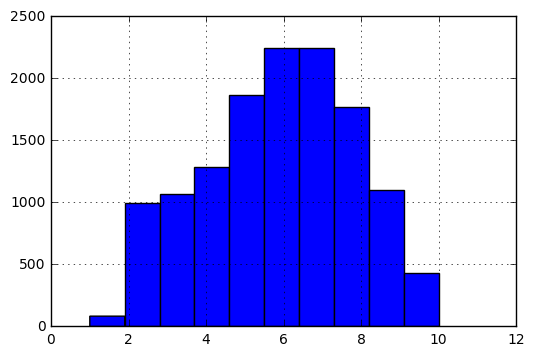

In [507]:
pd.Series(num_unique_sites).hist();

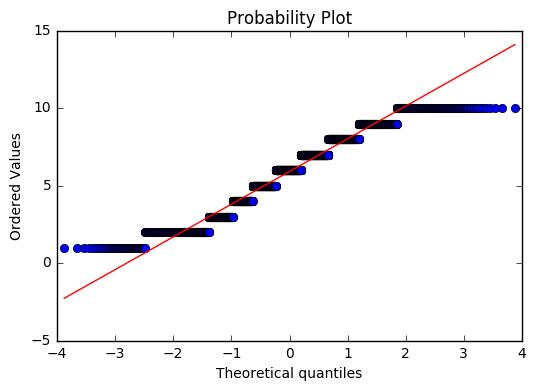

In [508]:
import pylab 
import scipy.stats as stats

measurements = pd.Series(num_unique_sites) 
stats.probplot(measurements, dist="norm", plot=pylab)
pylab.show()

In [509]:
stats.shapiro(measurements)

(0.9622764587402344, 0.0)

In [159]:
has_two_similar = (np.array(num_unique_sites) < 10).astype('int')

In [19]:
print (len(num_unique_sites) , num_unique_sites[:5])

13084 [8, 8, 7, 6, 10]


In [20]:
print (len(has_two_similar), has_two_similar[:5] )

13084 [1 1 1 1 0]


In [21]:
print ( sum(has_two_similar), len(train_df) )

12657 13084


In [510]:
stats.binom_test(sum(has_two_similar), len(train_df), p=0.95 )

4.0320826138955797e-22

In [511]:
from statsmodels.stats.proportion import proportion_confint
wilson_interval = proportion_confint(sum(has_two_similar), len(train_df), alpha=0.05, method='wilson')

In [512]:
print ('{} {}'.format( round(wilson_interval[0], 3), round(wilson_interval[1], 3)) )

0.964 0.97


In [513]:
sites_visited = list (train_df.iloc[:, :-1].as_matrix().ravel()) 
temp = sorted(Counter(sites_visited).items(), key=operator.itemgetter(1), reverse=True)
# print (temp)
sid_visits = list() 

sites_1000 = list()
total_visits = 0
for site in temp :
    if site[0] != 0 : # remove 0 element (no site) from the list
        total_visits += site[1]
        sid_visits.append(site)
        if (site[1] > 1000) :
            sites_1000.append(site[0])

site_freqs = {sid : val for (sid, val) in sid_visits}
site_ids = [sid  for (sid, val) in sid_visits]
site_visits = [val  for (sid, val) in sid_visits]
# print (total_visits, len(site_freqs), len(site_ids), len(sites_1000), sites_1000)
print ( np.mean(site_visits), len(site_ids) )
print (sites_1000)
print (sid_visits[:23])
print (site_visits[:23])
print (site_ids[:23])


26.62405862 4913
[2, 1, 3, 4, 5, 6, 9, 10, 8, 7, 13, 12, 11, 15, 14, 17, 18, 19, 20, 22, 24, 21, 23]
[(2, 7803), (1, 6227), (3, 5048), (4, 4063), (5, 4037), (6, 3747), (9, 2610), (10, 2068), (8, 2020), (7, 1858), (13, 1799), (12, 1682), (11, 1579), (15, 1491), (14, 1487), (17, 1379), (18, 1259), (19, 1230), (20, 1196), (22, 1040), (24, 1039), (21, 1033), (23, 1032)]
[7803, 6227, 5048, 4063, 4037, 3747, 2610, 2068, 2020, 1858, 1799, 1682, 1579, 1491, 1487, 1379, 1259, 1230, 1196, 1040, 1039, 1033, 1032]
[2, 1, 3, 4, 5, 6, 9, 10, 8, 7, 13, 12, 11, 15, 14, 17, 18, 19, 20, 22, 24, 21, 23]


In [164]:
import numpy as np
from matplotlib import pyplot

# sites_1000 = [2, 1, 3, 4, 5, 6, 9, 10, 8, 7, 13, 12, 11, 15, 14, 17, 18, 19, 20, 22, 23, 21, 24]
da = train_df.iloc[:, :-1].as_matrix().astype(int)
N, M = da.shape
df = np.zeros(11, dtype=int)
df_total = np.zeros(11, dtype=int)
list_mean = list()
for sid in sites_1000 :
    df = np.zeros(11, dtype=int)
    for i in range(N):
        k = 0
        for j in range(M):
            if da[i,j] == sid :
                k +=1
        df[k] +=1
    df_total += df

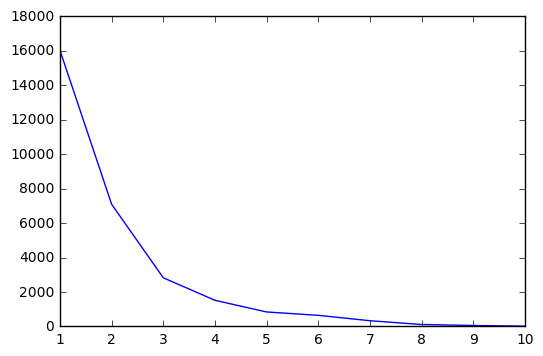

In [165]:
pyplot.plot( np.array(range(1,11)), df_total[1:] )
pyplot.show() 

In [9]:
def get_bootstrap_samples(data, n_samples):
    # np.random.seed(0)
    indices = np.random.randint(0, len(data), (n_samples, len(data)) )
    samples = data[indices]
    return samples

In [10]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [14]:
# 1 version
site_ids, site_freqs = np.unique(train_df.values[:, :-1],return_counts=True)

for i in range(len(site_ids)) :
    if site_ids[i] == 0 :
        site_ids = np.delete(site_ids, i)
        site_freqs = np.delete(site_freqs, i)
        # print ("deleted element ", i)
        break
sample_length = site_ids.shape[0]

print (len(site_freqs), site_freqs[:15])
mean_scores = list(map(np.mean, get_bootstrap_samples(site_freqs, sample_length)))


p = stat_intervals(mean_scores, 0.05)
print ('{} {}'.format( round(p[0], 3), round(p[1], 3)) )


4913 [6227 7803 5048 4063 4037 3747 1858 2020 2610 2068 1579 1682 1799 1487 1491]
21.164 33.06


In [14]:
# 4 version
temp = sorted(Counter(train_df.iloc[:, :-1].as_matrix().ravel()).items(), key=operator.itemgetter(1), reverse=True)
temp2 = [val  for (sid, val) in temp if sid != 0]
site_freqs = np.array(temp2)

print (len(site_freqs), site_freqs[:15])
mean_scores = list(map(np.mean, get_bootstrap_samples(site_freqs, sample_length)))

p = stat_intervals(mean_scores, 0.05)
print ('{} {}'.format( round(p[0], 3), round(p[1], 3)) )

4913 [7803 6227 5048 4063 4037 3747 2610 2068 2020 1858 1799 1682 1579 1491 1487]
21.113 33.058
